In [3]:
import numpy as np
import tqdm
import scipy
import pickle
import tools # this imports from tools.py, which is code I've written to deploy the sub_km distribution
import matplotlib.pyplot as plt
import pandas as pd

### First do some coding for a **slab** snowpack - no depth distribution

Makes two figures: one for constant ice thickness and different snow depths

The other with constant snow depth, variable ice thickness

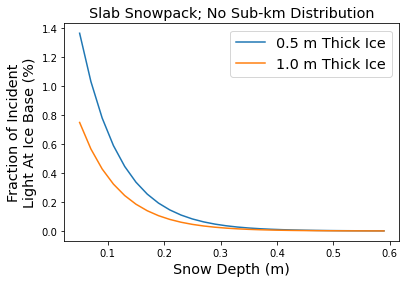

In [18]:
def get_light(incident_light,
              snow_depth,
              ice_thickness,
              snow_surface_albedo = 0.9,
              surface_scattering_layer_albedo = 0.5
                ):
    
    """Gets light transmittance through snow of a given depth
    
        Takes incident light (in this case 100 to give % remaining)
        
        Snow depth and ice thickness in metres.
        
        Works using Beer-Lambert and albedo values from Abraham et al. 2015 JGRO"""

    E_s = 14
    E_i = 1.2
    
    snow_transmitted = incident_light * (1-snow_surface_albedo)
    
    penetrated = snow_transmi
    
    
    ### YOU CAN DELETE THIS SECTION IF YOU JUST 
    ### WANT THE LIGHT THAT PENETRATES THE SNOW
    ### TO THE ICE SURFACE, AND NOT THE BASE
    
    incident_ice = snow_transmitted*np.exp(-E_s*snow_depth)
    
    trans_ice = incident_ice * (1 - surface_scattering_layer_albedo)
    
    incident_ice_bottom = trans_ice*np.exp(-E_i*ice_thickness)
    
    penetrated = incident_ice_bottom
    
    ################################################
    
    return incident_ice_bottom
    
ls1 = [] 
ls2 = []
sds = np.arange(0.05,0.6,0.02) # Define a bunch of snow depths to get ice-base-light for

for i in sds:
    ls1.append( get_light(incident_light=100,snow_depth=i,ice_thickness=0.5) ) #Work out light in case of SIT=0.5
    ls2.append( get_light(incident_light=100,snow_depth=i,ice_thickness=1.0) ) #case of SIT = 1


plt.plot(sds,ls1,label='0.5 m Thick Ice')
plt.plot(sds,ls2,label='1.0 m Thick Ice')
plt.ylabel('Fraction of Incident\nLight At Ice Base (%)',fontsize='x-large')
plt.xlabel('Snow Depth (m)',fontsize='x-large')
plt.legend(fontsize='x-large')
plt.title('Slab Snowpack; No Sub-km Distribution', fontsize='x-large')

plt.savefig('figures/light_loss_plot.jpg',bbox_inches='tight',dpi=400)

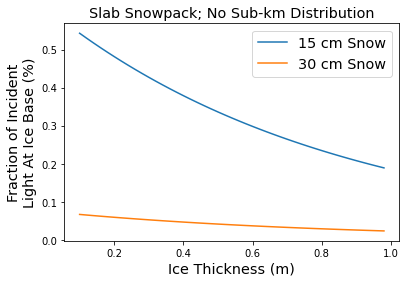

In [11]:
ls1 = [] 
ls2 = []

its = np.arange(0.1,1,0.02) #Bunch of SIT values to iterate over to get ice base light

for i in its:
    
    ls1.append( get_light(100,0.15,i) ) #Snow depth = 15cm
    ls2.append( get_light(100,0.3,i) ) #30cm

    
plt.plot(its,ls1,label='15 cm Snow')
plt.plot(its,ls2,label='30 cm Snow')
plt.ylabel('Fraction of Incident\nLight At Ice Base (%)',fontsize='x-large')
plt.xlabel('Ice Thickness (m)',fontsize='x-large')
plt.legend(fontsize='x-large')
plt.title('Slab Snowpack; No Sub-km Distribution', fontsize='x-large')

plt.savefig('figures/light_loss_plot_IT.jpg',bbox_inches='tight',dpi=400)

### Time to use the sub-km snow depth distribution.

I'll compare this to the slab-snowpack (above)

Also compasre to the distribution used in Stroeve et al. (2021)

https://doi.org/10.3389/fmars.2020.592337

First state the statistics of the skew-normal distribution from Mallett et al., 2022 (JGlac)

https://doi.org/10.1017/jog.2022.18

In [12]:
# Stats of distribution used in Mallett et al. 2022

statistics = {'a': 2.542562886886376,
  'loc': -1.114525560819975,
  'scale': 1.4973819434202296,
  'CV': 0.41696167189340216,
#   'n': 33539,
             }

## Make illustrative figure of the three depth distributions with mean depth = 0.3 m

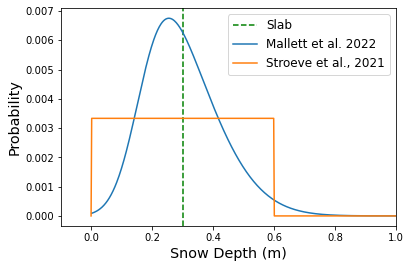

In [16]:
bin_width = 0.002
bin_edges = np.arange(0,2,bin_width)

mean_depth = 0.3

# Generate skew-normal snow depth distribution based on mean depth above

depth_bins, probability = tools.depth_distribution_from_depth(mean_depth=mean_depth,
                                                           dep_bin_edges=bin_edges,
                                                           statistics=statistics)

# Generate snow depth dist based on Stroeve et al., 2021 Frontiers
        
stroeve = [0] + [1/(2*mean_depth)*bin_width  if x<mean_depth*2 else 0 for x in depth_bins]
        
# Plot mean depth dashed line
plt.axvline(mean_depth,color='g',ls='--',label='Slab')
# Plot Skewnorm
plt.plot(depth_bins,probability,label='Mallett et al. 2022')
# Plot Stroeve with a (x=-0.001,y=0) prepended so the top-hat function is properly visualised
plt.plot([-0.001]+list(depth_bins),stroeve,label='Stroeve et al., 2021')

plt.xlim(-0.1,1.0)

plt.legend(fontsize='large')

plt.ylabel('Probability', fontsize='x-large')
plt.xlabel('Snow Depth (m)', fontsize='x-large')

plt.savefig('figures/distributions.jpg',bbox_inches='tight',dpi=400)

## To generate the light penetration, we need to *integrate* over the curves above.

$$ L =  \int_{0}^{\infty} f(d) dA $$

$L$ is the light flux that hits the ice base

$f(d)$ is the light that penetrates snow of a given depth based on Beer-Lambert

$dA$ is the fractional area covered by snow of a given depth based on the chosen snow depth distribution

Note that:

$$ 1 =  \int_{0}^{\infty} dA $$

## I'm not aware of a analytical integral to my skew-normal distribution, so I just integrate numerically as follows

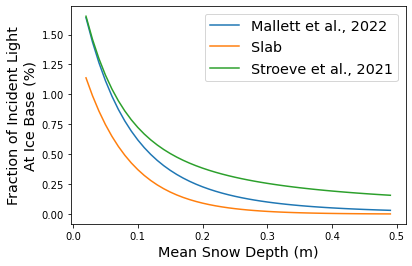

In [17]:
bin_width = 0.0002
bin_edges = np.arange(0,2,bin_width)

SL_eff = []
SN_eff = []
ST_eff = []

mean_depths = np.arange(0.02,0.5,.01)

for mean_depth in mean_depths:
    
    ### Get the Skew-Normal Depth Distribution from tools.py (in github repo)
    ### Use the statistics dictionary defined above
    ## SN_probability is short for skew-normal probability
    
    depth_bins, SN_probability = tools.depth_distribution_from_depth(mean_depth=mean_depth,
                                                           dep_bin_edges=bin_edges,
                                                       statistics=statistics)
    
    ### Get the Stroeve 2021 Depth Distribution (ST_probability)
    
    ST_probability = [1/(2*mean_depth)*bin_width  if x<mean_depth*2 else 0 for x in depth_bins]
    
    ### Get the light transmission through the depth bins
    ### Critically, this doesn't use a snow depth distribution yet!
    ### It just calculates the amount of light that makes it through the snow in each depth bin
    ### The depth distributions then tell us *how well represented* each depth bin is on the ice
    
    light_bins = get_light(100,depth_bins,0.7)
    
    ### Integrate the light transmission with respect to the two PDFs
    
    dist_cond_SN = np.sum(np.multiply(light_bins,SN_probability)) # Mallett et al. 2022 distribution
    
    dist_cond_ST = np.sum(np.multiply(light_bins,ST_probability)) # Stroeve et al. 2021 distribution
    
    SN_eff.append( dist_cond_SN ) # M '22 dist
    ST_eff.append( dist_cond_ST ) # S '21 dist
    SL_eff.append( get_light(100,mean_depth,1)) # Slab dist
                               
plt.plot(mean_depths, SN_eff, label='Mallett et al., 2022') 
plt.plot(mean_depths, SL_eff, label='Slab')
plt.plot(mean_depths, ST_eff, label='Stroeve et al., 2021')

plt.ylabel('Fraction of Incident Light\nAt Ice Base (%)', fontsize='x-large')
plt.xlabel('Mean Snow Depth (m)', fontsize='x-large')
plt.legend(fontsize='x-large')
# plt.show()

plt.savefig('figures/integrations.jpg',bbox_inches='tight',dpi=400)

## Make the same plot as above but with log-y axis

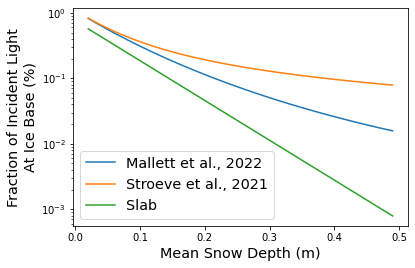

In [72]:
plt.plot(mean_depths, SN_eff, label='Mallett et al., 2022')                            
plt.plot(mean_depths, ST_eff, label='Stroeve et al., 2021')                            
plt.plot(mean_depths, SL_eff, label='Slab')
plt.yscale('log')
plt.ylabel('Fraction of Incident Light\nAt Ice Base (%)',fontsize='x-large')
plt.xlabel('Mean Snow Depth (m)',fontsize='x-large')
plt.legend(fontsize='x-large')
# plt.show()
plt.savefig('figures/integrations_log.jpg',bbox_inches='tight',dpi=400)

# Divide Mallett and Stroeve light fields by slab light field

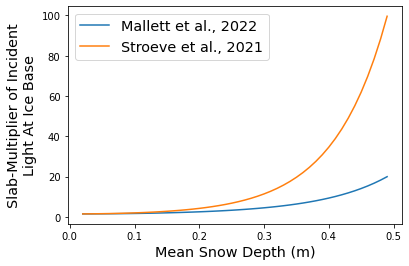

In [73]:
plt.plot(mean_depths, np.divide(SN_eff,SL_eff),label='Mallett et al., 2022')  
plt.plot(mean_depths, np.divide(ST_eff,SL_eff),label='Stroeve et al., 2021')
plt.ylabel('Slab-Multiplier of Incident\nLight At Ice Base',
           fontsize='x-large')
plt.xlabel('Mean Snow Depth (m)',fontsize='x-large')
# plt.yscale('log')
# plt.legend(fontsize='x-large')
tix = [1,2,4,8,16,32]
# plt.yticks(tix,labels=tix)
plt.legend(fontsize='x-large')

plt.savefig('figures/multipliers.jpg',bbox_inches='tight',dpi=400)

# Divide Mallett by Stroeve

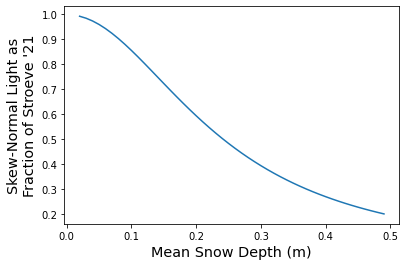

In [77]:
plt.plot(mean_depths, np.divide(SN_eff,ST_eff),label='Mallett et al., 2022')  
plt.ylabel("Skew-Normal Light as\nFraction of Stroeve '21",
           fontsize='x-large')
plt.xlabel('Mean Snow Depth (m)',fontsize='x-large')
# plt.yscale('log')
# plt.legend(fontsize='x-large')
tix = [1,2,4,8,16,32]
# plt.yticks(tix,labels=tix)
# plt.legend(fontsize='x-large')

plt.savefig('figures/multiplier_ST.jpg',bbox_inches='tight',dpi=400)